In [1]:
import pandas as pd
df = pd.read_excel("ETH.xlsx")
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)
df = df.dropna()

df['volatility'] = (df['high'] - df['low']) / df['close']
df['volume_prev'] = df['volume'].shift(1)
df['volatility_prev'] = df['volatility'].shift(1)

df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']
df['return'] = df['close'].pct_change()
df['return_delta'] = df['return'] - df['return'].shift(1)

df = df.dropna()

df.head()


,date,open,high,low,close,adj close,volume,volatility,volume_prev,volatility_prev,volume_delta,volatility_delta,return,return_delta
2,2020-12-08,591.90,594.75,552.47,554.83,554.83,14398919320,0.076204,1.072048e+10,0.029552,3.678438e+09,0.046652,-0.062534,-0.045804
3,2020-12-09,554.79,577.29,533.00,573.48,573.48,15855915840,0.077230,1.439892e+10,0.076204,1.456997e+09,0.001027,0.033614,0.096148
4,2020-12-10,573.50,574.60,549.78,559.68,559.68,11672582040,0.044347,1.585592e+10,0.077230,-4.183334e+09,-0.032883,-0.024064,-0.057678
5,2020-12-11,559.68,560.38,537.81,545.80,545.80,11098819124,0.041352,1.167258e+10,0.044347,-5.737629e+08,-0.002995,-0.024800,-0.000736
6,2020-12-12,545.58,573.34,545.25,568.57,568.57,8534557897,0.049405,1.109882e+10,0.041352,-2.564261e+09,0.008053,0.041719,0.066518


In [2]:
# Prepare feature (X) and target (y)
volume_changes = df['volume_delta'].values.reshape(-1, 1)
volatility_changes = df['volatility_delta'].values


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_model = LinearRegression()
linear_model.fit(volume_changes, volatility_changes)

linear_predictions = linear_model.predict(volume_changes)

linear_r2 = r2_score(volatility_changes, linear_predictions)

slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print("----- CRYPTO ETH: LINEAR MODEL -----")
print(f"R² Score: {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print(f"Equation: Δσ = {slope:.6e} × ΔV + {intercept:.6e}")

----- CRYPTO ETH: LINEAR MODEL -----
R² Score: 0.4279 (42.79%)
Equation: Δσ = 3.397332e-12 × ΔV + -1.385721e-05


In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(volume_changes)

poly_model = LinearRegression()
poly_model.fit(X_poly, volatility_changes)

poly_predictions = poly_model.predict(X_poly)

r2_poly = r2_score(volatility_changes, poly_predictions)

print("\n----- CRYPTO ETH: POLYNOMIAL MODEL (Degree 2) -----")
print(f"R² Score: {r2_poly:.4f} ({r2_poly*100:.2f}%)")


----- CRYPTO ETH: POLYNOMIAL MODEL (Degree 2) -----
R² Score: 0.4327 (43.27%)


In [6]:
print("\n----- CRYPTO MODEL COMPARISON -----")
print(f"Linear R²:     {linear_r2:.4f}")
print(f"Polynomial R²: {r2_poly:.4f}")

improvement = r2_poly - linear_r2

print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")

if r2_poly > linear_r2:
    print(f"Polynomial model is better by {improvement*100:.2f}%")
else:
    print("Linear model is better for crypto.")


----- CRYPTO MODEL COMPARISON -----
Linear R²:     0.4279
Polynomial R²: 0.4327

Improvement: 0.0048 (0.48%)
Polynomial model is better by 0.48%


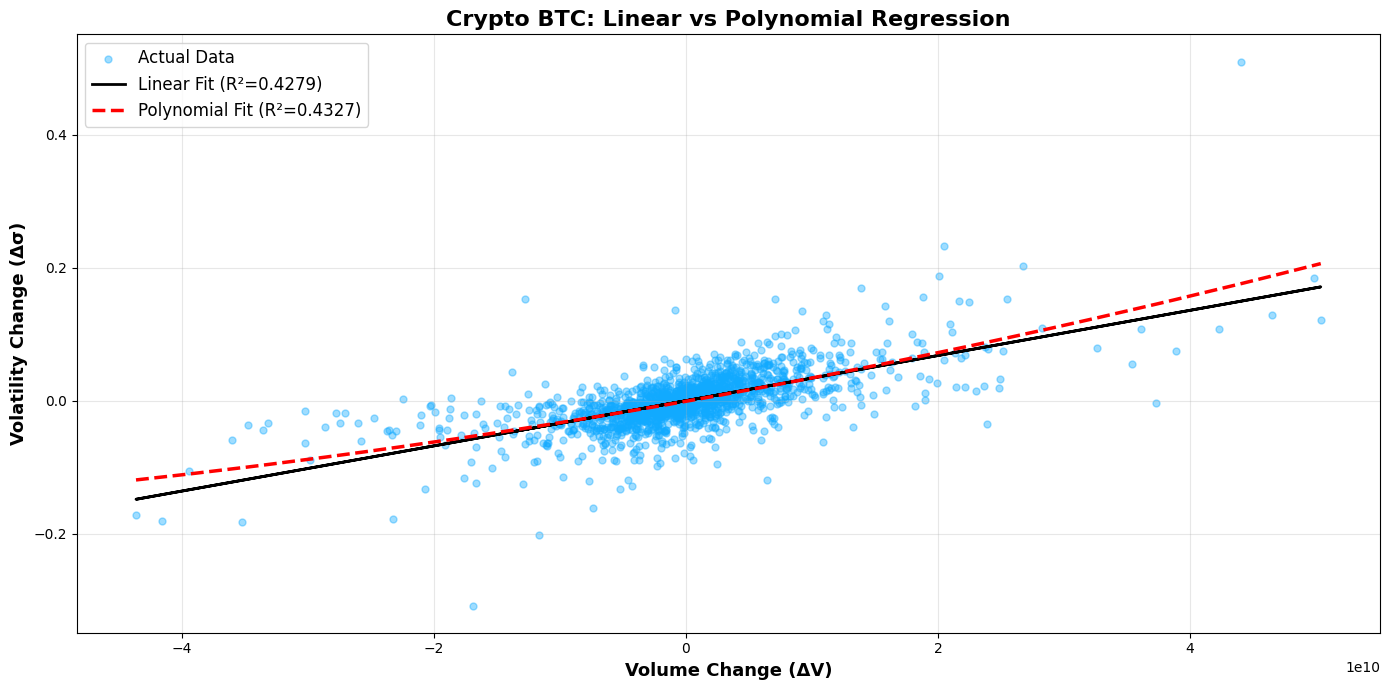

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Scatter plot
plt.scatter(volume_changes, volatility_changes,
            alpha=0.4, s=25, color='#11aaff',
            label='Actual Data')

# Linear fit
plt.plot(volume_changes, linear_predictions,
         color='black', linewidth=2,
         label=f'Linear Fit (R²={linear_r2:.4f})')

# Sorted polynomial fit
sorted_idx = np.argsort(volume_changes.flatten())
plt.plot(volume_changes[sorted_idx], poly_predictions[sorted_idx],
         color='red', linewidth=2.5, linestyle='--',
         label=f'Polynomial Fit (R²={r2_poly:.4f})')

plt.xlabel("Volume Change (ΔV)", fontsize=13, fontweight="bold")
plt.ylabel("Volatility Change (Δσ)", fontsize=13, fontweight="bold")
plt.title("Crypto BTC: Linear vs Polynomial Regression", fontsize=16, fontweight="bold")

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

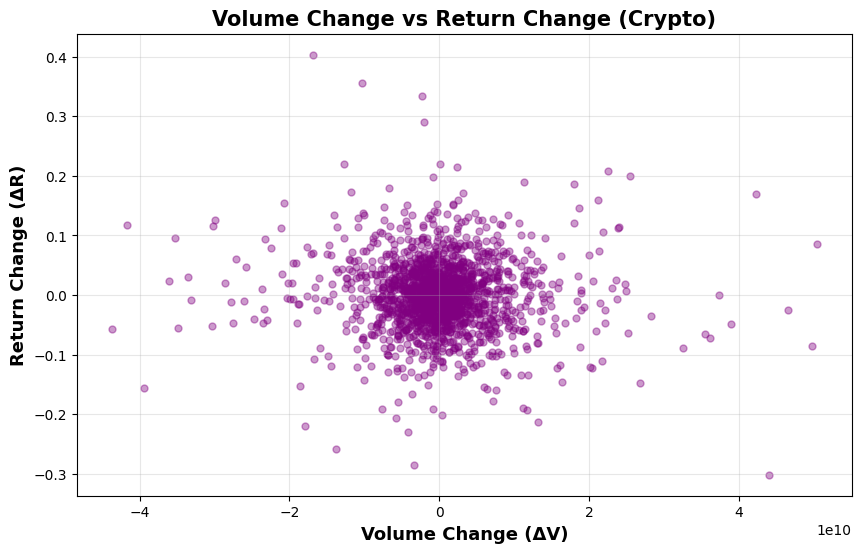

In [8]:
plt.figure(figsize=(10,6))

plt.scatter(df['volume_delta'], df['return_delta'],
            alpha=0.4, s=25, color='purple')

plt.xlabel("Volume Change (ΔV)", fontsize=13, fontweight="bold")
plt.ylabel("Return Change (ΔR)", fontsize=13, fontweight="bold")
plt.title("Volume Change vs Return Change (Crypto)", fontsize=15, fontweight="bold")

plt.grid(True, alpha=0.3)
plt.show()